##Project 2: Time Series

In [43]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [44]:
train = pd.read_csv('/content/drive/MyDrive/DATA/daily-max-temperatures.csv')
train.head()

,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


In [45]:
train.describe

<bound method NDFrame.describe of             Date  Temperature
0     1981-01-01         38.1
1     1981-01-02         32.4
2     1981-01-03         34.5
3     1981-01-04         20.7
4     1981-01-05         21.5
...          ...          ...
3645  1990-12-27         37.6
3646  1990-12-28         23.2
3647  1990-12-29         25.1
3648  1990-12-30         24.4
3649  1990-12-31         24.6

[3650 rows x 2 columns]>

In [46]:
train.isnull().sum()

Date           0
Temperature    0
dtype: int64

In [47]:
train['Temperature'] = train['Temperature'].astype(float)

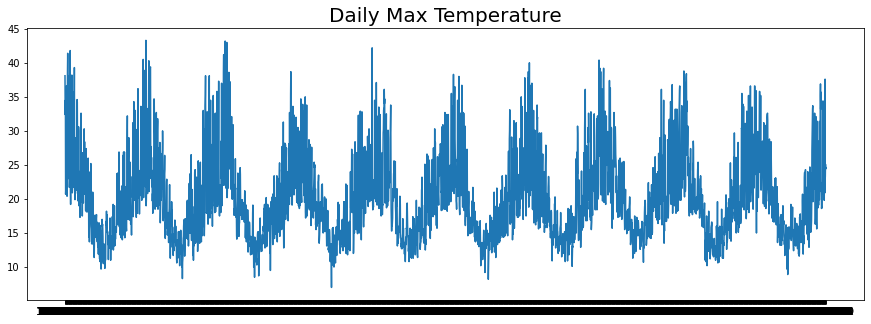

In [48]:
dates = train['Date'].values
temp  = train['Temperature'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Daily Max Temperature',
          fontsize=20);

In [52]:
date_temp, date_test, temp_train, temp_test  = train_test_split(dates, temp, test_size=0.2, shuffle=False)

In [53]:
def windowed(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [54]:
train_set = windowed(temp_train, window_size=60, batch_size=120, shuffle_buffer=1000)
test_set = windowed(temp_test, window_size=60, batch_size=120, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])

In [55]:
tresshold = (train['Temperature'].max() - train['Temperature'].min()) * 10/100
print(tresshold)

3.63


In [56]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<tresshold) & (logs.get('val_mae')<tresshold):
      print('\sudah mencapai <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [58]:
history = model.fit(train_set, 
                    validation_data=(test_set),
                    epochs=100,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
24/24 - 8s - loss: 19.1387 - mae: 19.6387 - val_loss: 18.9259 - val_mae: 19.4259 - 8s/epoch - 348ms/step
Epoch 2/100
24/24 - 3s - loss: 18.9910 - mae: 19.4910 - val_loss: 18.7879 - val_mae: 19.2879 - 3s/epoch - 137ms/step
Epoch 3/100
24/24 - 3s - loss: 18.8382 - mae: 19.3382 - val_loss: 18.6289 - val_mae: 19.1289 - 3s/epoch - 137ms/step
Epoch 4/100
24/24 - 3s - loss: 18.6733 - mae: 19.1733 - val_loss: 18.4506 - val_mae: 18.9506 - 3s/epoch - 139ms/step
Epoch 5/100
24/24 - 3s - loss: 18.4791 - mae: 18.9791 - val_loss: 18.2379 - val_mae: 18.7379 - 3s/epoch - 129ms/step
Epoch 6/100
24/24 - 3s - loss: 18.2462 - mae: 18.7462 - val_loss: 17.9811 - val_mae: 18.4811 - 3s/epoch - 138ms/step
Epoch 7/100
24/24 - 3s - loss: 17.9613 - mae: 18.4613 - val_loss: 17.6617 - val_mae: 18.1617 - 3s/epoch - 137ms/step
Epoch 8/100
24/24 - 3s - loss: 17.6042 - mae: 18.1042 - val_loss: 17.2598 - val_mae: 17.7598 - 3s/epoch - 137ms/step
Epoch 9/100
24/24 - 3s - loss: 17.1513 - mae: 17.6513 - val_loss

In [60]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

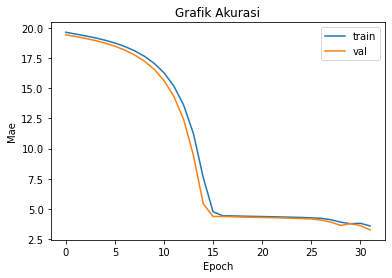

In [63]:
plt.plot(mae)
plt.plot(val_mae)
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Mae')
plt.legend(['train', 'val'], loc = 'best')

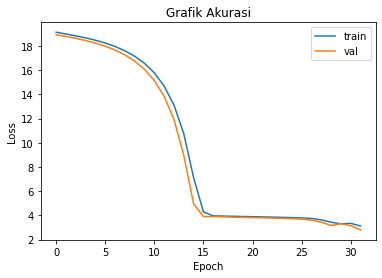

In [65]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc = 'best')